In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

## <center>数据准备</center>

In [2]:
Data = namedtuple('Data', ['feature', 'label', 'adj', 
                  'train_mask', 'val_mask', 'test_mask'])

class Cora():
    def __init__(self, path='../../data_process/data/cora/', dataset='cora'):
        self.path = path
        self.dataset = dataset
        

    def process_data(self):
        id_feature_label = np.genfromtxt('{path}{dataset}.content'
                                    .format(path=self.path, dataset=self.dataset)
                                    , dtype=np.dtype(str))
    
        feature = np.array(id_feature_label[:, 1:-1], dtype=np.float32)
        feature = feature / feature.sum(1, keepdims=True)

        label = np.array(pd.get_dummies(id_feature_label[:, -1]), dtype=np.int32)
        print(label)
        
        def build_adjcency(id_feature_label, label):
            id = np.array(id_feature_label[:, 0], dtype=np.int32)
            id_map = {j: i for i, j in enumerate(id)}

            edges = np.genfromtxt("{path}{dataset}.cites".format(path=self.path, dataset=self.dataset)
                                    , dtype=np.int32)

            edges_order_by_id = np.array(list(map(id_map.get, edges.flatten())), dtype=np.int32) \
                                .reshape(edges.shape)

            row = edges_order_by_id[:, 0]
            col = edges_order_by_id[:, 1]
            data = np.ones(edges_order_by_id.shape[0])
            adj = sp.coo_matrix((data, (row, col))
                                            , shape=(label.shape[0], label.shape[0])
                                            , dtype=np.float32)
            return adj

        adj = build_adjcency(id_feature_label, label)

        adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

        def normalize(adj):
            adj += sp.eye(adj.shape[0])
            degree = np.array(adj.sum(1))
            d_hat = sp.diags(np.power(degree, -0.5).flatten())
            return d_hat.dot(adj).dot(d_hat).tocoo()
        
        adj = normalize(adj)

        index_train = range(140)
        index_val = range(140, 640)
        index_test = range(1708, 2708)

        def sample_mask(index, length):
            mask = np.zeros(length)
            mask[index] = 1
            return np.array(mask, dtype=np.bool_)
        
        length = label.shape[0]

        train_mask = sample_mask(index_train, length)
        val_mask = sample_mask(index_val, length)
        test_mask = sample_mask(index_test, length)

        print(feature.shape, type(feature))
        print(label.shape, type(label))
        print(adj.shape, type(adj))
        print(train_mask.shape, type(train_mask))
        print(val_mask.shape, type(val_mask))
        print(test_mask.shape, type(test_mask))
     
        feature = torch.from_numpy(np.array(feature))
        label = torch.LongTensor(np.where(label)[1])

        def sparse_mx_to_torch_sparse_tensor(sparse_mx):
            """Convert a scipy sparse matrix to a torch sparse tensor."""
            sparse_mx = sparse_mx.tocoo().astype(np.float32)
            indices = torch.from_numpy(
                np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
            values = torch.from_numpy(sparse_mx.data)
            shape = torch.Size(sparse_mx.shape)
            return torch.sparse.FloatTensor(indices, values, shape)

        adj = sparse_mx_to_torch_sparse_tensor(adj)

        train_mask = torch.from_numpy(train_mask)
        val_mask = torch.from_numpy(val_mask)
        test_mask = torch.from_numpy(test_mask)
    
        return Data(feature, label, adj, train_mask, val_mask, test_mask)
    

## <center>图卷积层定义</center>

In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'


## <center>模型定义</center>

In [4]:
class GCN(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits
    

## <center>模型训练</center>

In [5]:
# 定义超参数
LEARNING_RATE = 0.1 # 学习率
WEIGHT_DACAY = 5e-4 # 权重衰减
EPOCHS = 200
DEVICE = 'cpu'

In [6]:
dataset = Cora().process_data()
feature = dataset.feature
label = dataset.label
adj = dataset.adj
train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask

# print(feature.shape, type(feature))
# print(label.shape, type(label))
# print(adj.shape, type(adj))
# print(train_mask.shape, type(train_mask))
# print(val_mask.shape, type(val_mask))
# print(test_mask.shape, type(test_mask))

input_dim = 1433


[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
(2708, 1433) <class 'numpy.ndarray'>
(2708, 7) <class 'numpy.ndarray'>
(2708, 2708) <class 'scipy.sparse.coo.coo_matrix'>
(2708,) <class 'numpy.ndarray'>
(2708,) <class 'numpy.ndarray'>
(2708,) <class 'numpy.ndarray'>


In [7]:
model = GCN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)


In [8]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_label = label[train_mask]
    for epoch in range(EPOCHS):
        logits = model(adj, feature)  # 前向传播
        train_mask_logits = logits[train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_label)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history

In [9]:
# 测试函数
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(adj, feature)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, label[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), label[mask].cpu().numpy()

In [10]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

In [11]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 1.9513, TrainAcc 0.3429, ValAcc 0.3740
Epoch 001: Loss 1.8548, TrainAcc 0.4071, ValAcc 0.3800
Epoch 002: Loss 1.7554, TrainAcc 0.45, ValAcc 0.4240
Epoch 003: Loss 1.6595, TrainAcc 0.4643, ValAcc 0.4340
Epoch 004: Loss 1.5799, TrainAcc 0.4857, ValAcc 0.4520
Epoch 005: Loss 1.4806, TrainAcc 0.4857, ValAcc 0.4380
Epoch 006: Loss 1.3858, TrainAcc 0.5214, ValAcc 0.4660
Epoch 007: Loss 1.2882, TrainAcc 0.5357, ValAcc 0.4800
Epoch 008: Loss 1.1919, TrainAcc 0.55, ValAcc 0.4820
Epoch 009: Loss 1.0998, TrainAcc 0.5929, ValAcc 0.4900
Epoch 010: Loss 1.0172, TrainAcc 0.6286, ValAcc 0.5420
Epoch 011: Loss 0.9398, TrainAcc 0.7571, ValAcc 0.6060
Epoch 012: Loss 0.8541, TrainAcc 0.85, ValAcc 0.6700
Epoch 013: Loss 0.7799, TrainAcc 0.8857, ValAcc 0.7060
Epoch 014: Loss 0.7077, TrainAcc 0.9143, ValAcc 0.7320
Epoch 015: Loss 0.6453, TrainAcc 0.9571, ValAcc 0.7560
Epoch 016: Loss 0.5851, TrainAcc 0.9786, ValAcc 0.7940
Epoch 017: Loss 0.5299, TrainAcc 0.9786, ValAcc 0.8100
Epoch 018: Loss 

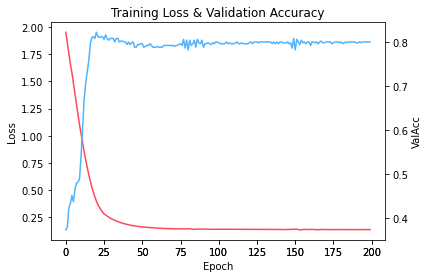

In [12]:
plot_loss_with_acc(loss, val_acc)

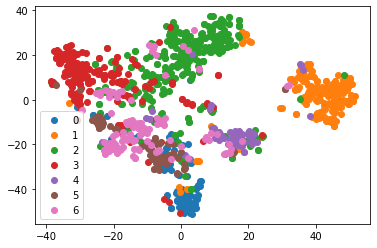

In [13]:
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()